
# Librerias necesarias

In [ ]:
# prompt: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.
# Instalar las dependencias necesarias
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [ ]:
!pip install torch
!pip install networkx

# Preparación

## Cargamos los datos

In [ ]:
# prompt: carga los datos /content/Promedio_por_POINTID.xlsx

import pandas as pd

# Carga el archivo Excel
df = pd.read_excel('/content/Promedio_por_POINTID.xlsx')

# Muestra las primeras filas del DataFrame para verificar la carga
print(df.head())


   POINTID  Longitud    Latitud  S2_B1_month_avg  S2_B2_month_avg  \
0    67887 -7.583333  38.000000      2748.056187      2557.544192   
1    67918 -7.583333  38.083333      2765.294192      2533.945950   
2    68001 -7.750000  38.016667      2716.889141      2499.290530   
3    68243 -7.866667  38.016667      2757.005556      2531.513889   
4    68244 -7.866667  38.016667      2757.005556      2531.513889   

   S2_B3_month_avg  S2_B4_month_avg  S2_B5_month_avg  S2_B6_month_avg  \
0      2397.352273      2526.786616      2721.671717      3287.449495   
1      2403.910402      2560.957799      2788.474942      3318.448135   
2      2302.891288      2361.154040      2518.281566      3125.288384   
3      2388.669444      2697.783333      2807.080556      3094.619444   
4      2388.669444      2697.783333      2807.080556      3094.619444   

   S2_B7_month_avg  ...  S3_B20_month_avg  S3_B21_month_avg  \
0      3613.507576  ...         19.375000         57.583333   
1      3610.854167  

## Caracteristicas nodo

## Preprocesamiento

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Definir las características de los nodos (excepto OC, Longitud y Latitud)
node_features = df.drop(columns=['OC', 'Longitud', 'Latitud']).values
target = np.log(df['OC'].values)
coordinates = df[['Latitud', 'Longitud']].values  # Asegúrate de que las coordenadas estén en este orden: [Latitud, Longitud]

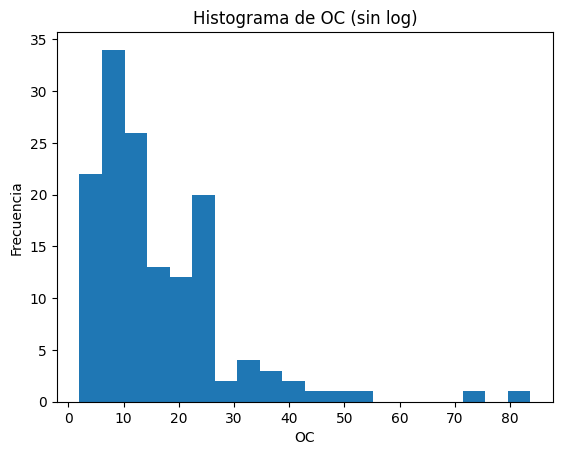

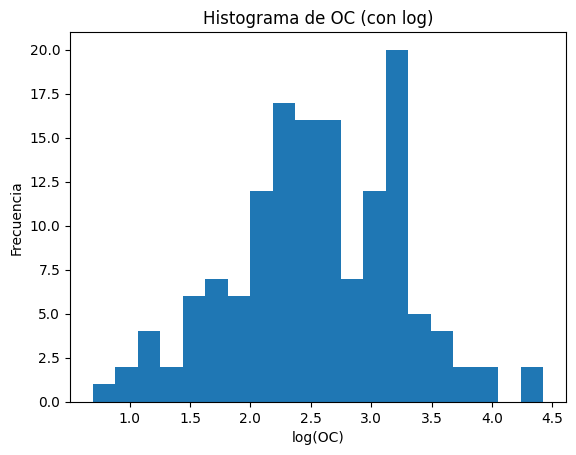

In [ ]:
# Histograma de target sin log
plt.hist(df['OC'], bins=20)
plt.title('Histograma de OC (sin log)')
plt.xlabel('OC')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de target con log
plt.hist(target, bins=20)
plt.title('Histograma de OC (con log)')
plt.xlabel('log(OC)')
plt.ylabel('Frecuencia')
plt.show()


## Caracteristica arcos

In [ ]:
import networkx as nx
from sklearn.model_selection import train_test_split

### Función de distancia haversine

In [ ]:
# Función para calcular la distancia de Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radio de la Tierra en kilómetros
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convertir de grados a radianes

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c  # Distancia en kilómetros


In [ ]:
# Calcular la matriz de distancias entre los nodos (usando las coordenadas geográficas)
n = len(coordinates)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = haversine(coordinates[i][0], coordinates[i][1], coordinates[j][0], coordinates[j][1])

## Construccion arcos

In [ ]:
# Definir el número de vecinos a considerar
k_neighbors = 3

# Crear las aristas entre los nodos más cercanos
edges = []
edge_attr = []
for i in range(dist_matrix.shape[0]):
    nearest_neighbors = np.argsort(dist_matrix[i, :])[:k_neighbors + 1]  # Incluir k vecinos
    for neighbor in nearest_neighbors[1:]:  # Omitir la conexión consigo mismo
        edges.append([i, neighbor])
        edge_attr.append(dist_matrix[i, neighbor])

edges = np.array(edges).T  # Convertir a formato (2, num_edges)

# Creamos el grafo para realizar gráficos

In [ ]:
# Crear el grafo usando NetworkX
G = nx.Graph()

# Agregar los nodos con las coordenadas como posiciones
for i, (lat, lon) in enumerate(coordinates):
    G.add_node(i, pos=(lon, lat))  # Usamos (Longitud, Latitud) para graficar correctamente

# Agregar las aristas (conexiones entre nodos) al grafo
for i, j in zip(edges[0], edges[1]):
    G.add_edge(i.item(), j.item(), weight=dist_matrix[i, j])

# Obtener las posiciones de los nodos
pos = nx.get_node_attributes(G, 'pos')

### Grafico general

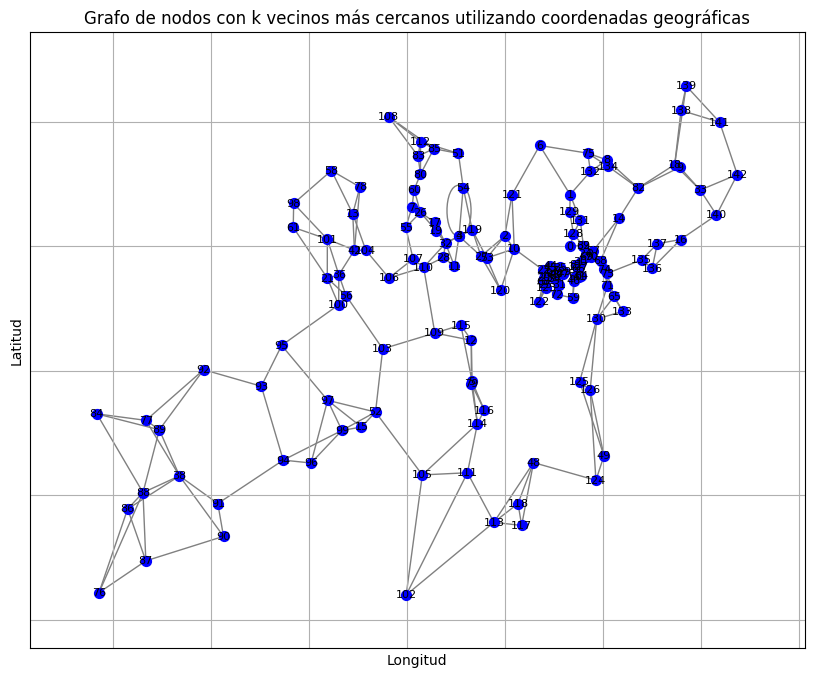

In [ ]:
# Graficar el grafo con las posiciones geográficas
plt.figure(figsize=(10, 8))

# Dibujar los nodos (coordenadas geográficas)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')

# Dibujar las aristas (conexiones entre los nodos más cercanos)
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Etiquetas opcionales para los nodos
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('Grafo de nodos con k vecinos más cercanos utilizando coordenadas geográficas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show()

### Grafico con los valores del soc normalizados

<ipython-input-13-9f5613946b54>:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Contenido de carbono orgánico (SOC)")


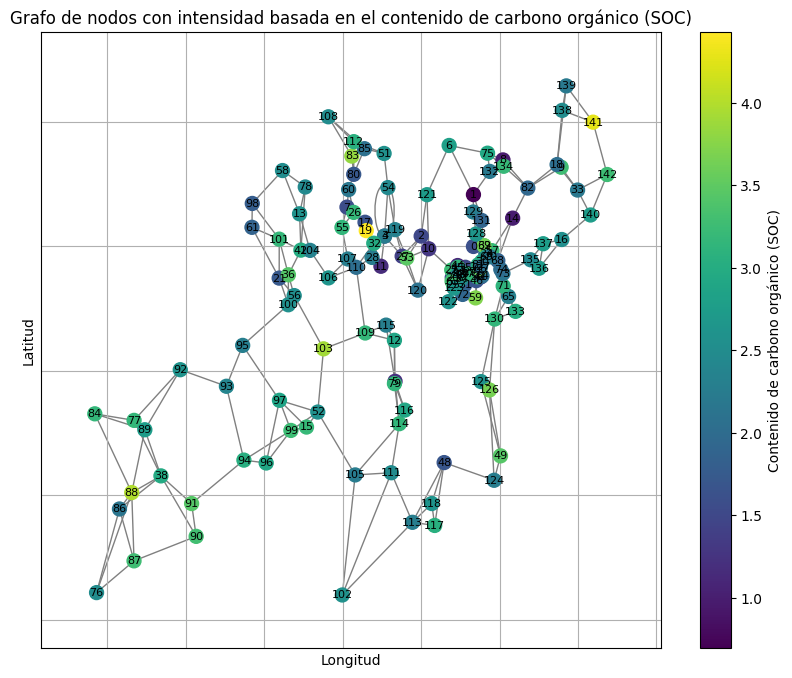

In [ ]:
# Normalizar los valores de SOC para usarlos como colores de los nodos
norm_soc = (target - target.min()) / (target.max() - target.min())  # Normalizar entre 0 y 1

# Graficar el grafo con las posiciones geográficas
plt.figure(figsize=(10, 8))

# Dibujar los nodos con los colores en función de los valores de SOC
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=norm_soc, cmap=plt.cm.viridis)

# Dibujar las aristas (conexiones entre los nodos más cercanos)
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Añadir una barra de colores para representar la intensidad de los valores SOC
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=target.min(), vmax=target.max()))
sm.set_array([])
plt.colorbar(sm, label="Contenido de carbono orgánico (SOC)")

# Etiquetas opcionales para los nodos
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('Grafo de nodos con intensidad basada en el contenido de carbono orgánico (SOC)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show()

# Identificacion de las muestras

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.utils import to_undirected

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:
# Función para expandir la máscara con los vecinos de los nodos seleccionados
def expand_with_neighbors(mask, edge_index):
    new_mask = mask.clone()  # Copiar la máscara original
    for i, node in enumerate(mask):
        if node:  # Si el nodo está en la máscara original
            # Buscar todos los vecinos directos del nodo
            neighbors = edge_index[1][edge_index[0] == i]
            # Incluir los vecinos en la nueva máscara
            new_mask[neighbors] = True
    return new_mask

In [ ]:
# Crear máscaras de entrenamiento, validación y prueba
n = df.shape[0]
train_idx, test_idx = train_test_split(range(n), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Inicializar máscaras de entrenamiento, validación y prueba
train_mask = torch.zeros(n, dtype=torch.bool)
val_mask = torch.zeros(n, dtype=torch.bool)
test_mask = torch.zeros(n, dtype=torch.bool)

# Asignar los nodos correspondientes a las máscaras
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Convertir `edges` a tensor de PyTorch (debe ser de tipo long)
edges = torch.tensor(edges, dtype=torch.long)

# Asegurarse de que las aristas sean no dirigidas (para incluir vecinos en ambos sentidos)
edge_index = to_undirected(edges)

# guardar los nodos
# Expander las máscaras con los vecinos
train_mask_o = train_mask
val_mask_o = val_mask
test_mask_o = test_mask
# Expander las máscaras con los vecinos
train_mask = expand_with_neighbors(train_mask, edge_index)
val_mask = expand_with_neighbors(val_mask, edge_index)
test_mask = expand_with_neighbors(test_mask, edge_index)

# Verificar las máscaras expandidas
print(f"Número de nodos en el conjunto de entrenamiento (incluyendo vecinos): {train_mask.sum().item()}")
print(f"Número de nodos en el conjunto de validación (incluyendo vecinos): {val_mask.sum().item()}")
print(f"Número de nodos en el conjunto de prueba (incluyendo vecinos): {test_mask.sum().item()}")


Número de nodos en el conjunto de entrenamiento (incluyendo vecinos): 142
Número de nodos en el conjunto de validación (incluyendo vecinos): 94
Número de nodos en el conjunto de prueba (incluyendo vecinos): 97


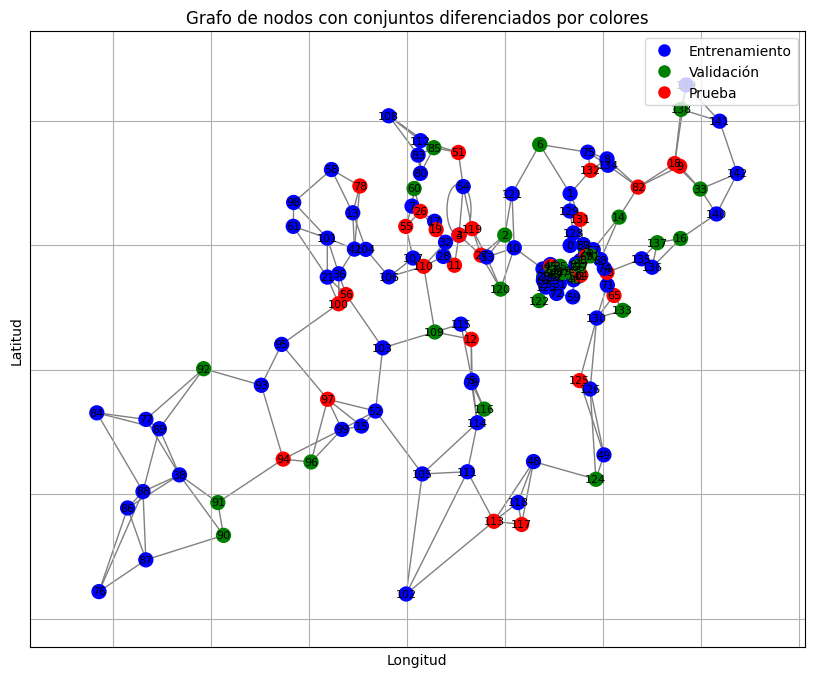

In [ ]:
# Función para crear y graficar los grafos de entrenamiento, validación y prueba con colores
def graficar_grafo_con_muestras(train_idx, val_idx, test_idx):
    G = nx.Graph()

    # Agregar nodos con posiciones geográficas basadas en los índices del conjunto
    for i in range(n):
        G.add_node(i, pos=(coordinates[i][1], coordinates[i][0]))  # [Longitud, Latitud]

    # Agregar las aristas basadas en las conexiones de los k vecinos
    for i, j in zip(edges[0], edges[1]):
        G.add_edge(i.item(), j.item(), weight=dist_matrix[i, j])

    # Obtener las posiciones de los nodos
    pos = nx.get_node_attributes(G, 'pos')

    # Colorear los nodos según su conjunto (entrenamiento, validación, prueba)
    color_map = []
    for i in range(n):
        if i in train_idx:
            color_map.append('blue')  # Entrenamiento en azul
        elif i in val_idx:
            color_map.append('green')  # Validación en verde
        else:
            color_map.append('red')  # Prueba en rojo

    # Graficar el grafo
    plt.figure(figsize=(10, 8))

    # Dibujar los nodos, coloreados por conjunto
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map)

    # Dibujar las aristas
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Etiquetas opcionales para los nodos
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Añadir leyenda para identificar cada conjunto
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Entrenamiento'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Validación'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Prueba')
    ], loc='upper right')

    plt.title('Grafo de nodos con conjuntos diferenciados por colores')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.grid(True)
    plt.show()

# Graficar el grafo con los conjuntos de entrenamiento, validación y prueba diferenciados por colores
graficar_grafo_con_muestras(train_idx, val_idx, test_idx)


# Fijar semillas

In [ ]:
import random

# Fijar las semillas para reproducibilidad
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Para todos los GPUs si se usan múltiples GPUs
    torch.backends.cudnn.deterministic = True  # Asegurar operaciones deterministas en CUDNN
    torch.backends.cudnn.benchmark = False  # Desactivar optimizaciones que pueden causar variabilidad

# Fijar la semilla con un valor específico
SEED = 42
set_seed(SEED)

## Modelación

<ipython-input-19-263c9a87244a>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges = torch.tensor(edges, dtype=torch.long)


Época 10, Pérdida de entrenamiento: 0.1197, Pérdida de validación: 0.1370
Época 20, Pérdida de entrenamiento: 0.0693, Pérdida de validación: 0.0859
Época 30, Pérdida de entrenamiento: 0.0495, Pérdida de validación: 0.0580
Época 40, Pérdida de entrenamiento: 0.0342, Pérdida de validación: 0.0413
Época 50, Pérdida de entrenamiento: 0.0246, Pérdida de validación: 0.0306
R² en el conjunto de prueba: 0.7320


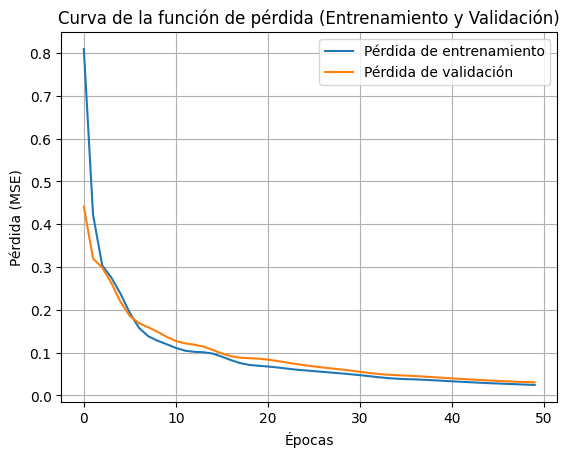

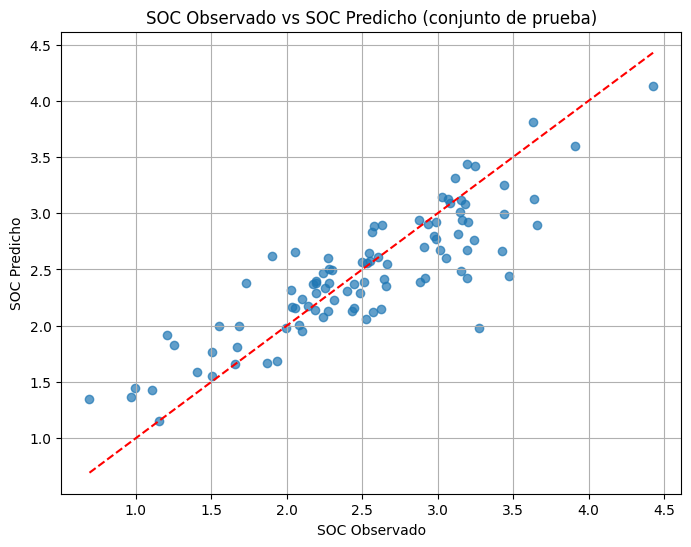

Error absoluto medio (MAE) en el conjunto de prueba: 0.2777
R² en el conjunto de prueba: 0.7326


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import ChebConv
import numpy as np
from torch_geometric.data import Data
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Definir el modelo GNN con ChebConv
class GNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNN, self).__init__()
        # Chebyshev Convolutional layers
        self.conv1 = ChebConv(in_channels, 16, K=1)  # 16 hidden units, Chebyshev order 1
        self.conv2 = ChebConv(16, 32, K=1)  # Second layer with 32 hidden units
        self.conv3 = ChebConv(32, out_channels, K=1)  # Output layer

        # Activation
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First convolutional layer
        x = self.conv1(x, edge_index)
        x = self.relu(x)

        # Second convolutional layer
        x = self.conv2(x, edge_index)
        x = self.relu(x)

        # Output layer
        x = self.conv3(x, edge_index)
        return x

# 1. Normalizar las características de los nodos (x) usando la muestra de entrenamiento
def normalize_features(x, train_mask):
    # Calcular la media y desviación estándar solo en los nodos de entrenamiento
    mean = x[train_mask].mean(dim=0)
    std = x[train_mask].std(dim=0)

    # Evitar división por cero en características con desviación estándar 0
    std[std == 0] = 1

    # Normalizar todas las características usando la media y desviación estándar de entrenamiento
    x_norm = (x - mean) / std
    return x_norm

# 2. Aplicar logaritmo a los valores de SOC (y)
def log_transform_target(y):
    # Asegurarse de que no haya valores menores o iguales a 0
    y[y <= 0] = 1e-6
    # Aplicar logaritmo
    return torch.log(y)

# Supongamos que los datos node_features, edges, y target ya están cargados como tensores de PyTorch
# Convertimos todo a tensores, si no lo están ya
node_features = torch.tensor(node_features, dtype=torch.float)
edges = torch.tensor(edges, dtype=torch.long)
target = torch.tensor(target, dtype=torch.float)

# Máscaras de entrenamiento, validación y prueba (ya generadas previamente)
# train_mask, val_mask, test_mask

# Normalizar las características de los nodos
node_features_normalized = normalize_features(node_features, train_mask)

# Aplicar logaritmo a los valores de SOC
target_log = log_transform_target(target)

# Crear los datos para PyTorch Geometric
data = Data(
    x=node_features_normalized,
    edge_index=edges,
    y=target_log.unsqueeze(1)  # Asegurarse de que sea una columna (Nx1)
)

# Definir el modelo
in_channels = node_features_normalized.shape[1]  # Número de características de los nodos
out_channels = 1  # Una sola salida (log SOC)
model = GNN(in_channels, out_channels)

# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento del modelo
model.train()
train_losses = []  # Inicializar lista de pérdidas de entrenamiento
val_losses = []  # Inicializar lista de pérdidas de validación
num_epochs = 50

for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model(data)  # Predicción para todos los nodos
    loss = criterion(out[train_mask], data.y[train_mask])  # Pérdida solo en los nodos de entrenamiento
    loss.backward()
    optimizer.step()

    # Guardar la pérdida de entrenamiento
    train_losses.append(loss.item())

    # Evaluación en los nodos de validación
    model.eval()
    with torch.no_grad():
        val_out = model(data)
        val_loss = criterion(val_out[val_mask], data.y[val_mask])
        val_losses.append(val_loss.item())
    model.train()

    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch + 1}, Pérdida de entrenamiento: {loss.item():.4f}, Pérdida de validación: {val_loss.item():.4f}")

# Evaluación en el conjunto de prueba
model.eval()
with torch.no_grad():
    test_out = model(data)
    test_pred = test_out[test_mask].numpy()
    test_true = data.y[test_mask].numpy()

    # Calcular R² en el conjunto de prueba
    r2 = r2_score(test_true, test_pred)
    print(f"R² en el conjunto de prueba: {r2:.4f}")

# Graficar la función de pérdida
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.plot(val_losses, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Curva de la función de pérdida (Entrenamiento y Validación)')
plt.grid(True)
plt.show()

# Inversión del logaritmo para obtener los valores originales de SOC
test_pred_inv = np.exp(test_pred)
test_true_inv = np.exp(test_true)

# Graficar valores SOC observados vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(test_true_inv, test_pred_inv, alpha=0.7)
plt.plot([min(test_true_inv), max(test_true_inv)], [min(test_true_inv), max(test_true_inv)], color='red', linestyle='--')
plt.xlabel('SOC Observado')
plt.ylabel('SOC Predicho')
plt.title('SOC Observado vs SOC Predicho (conjunto de prueba)')
plt.grid(True)
plt.show()

# Calcular el error absoluto medio (MAE)
mae = np.mean(np.abs(test_true_inv - test_pred_inv))
print(f"Error absoluto medio (MAE) en el conjunto de prueba: {mae:.4f}")

r2 = r2_score(test_true_inv, test_pred_inv)
print(f"R² en el conjunto de prueba: {r2:.4f}")


R² de la regresión lineal: 0.7451
Ecuación de la línea de regresión: y = 0.6689x + 0.7809


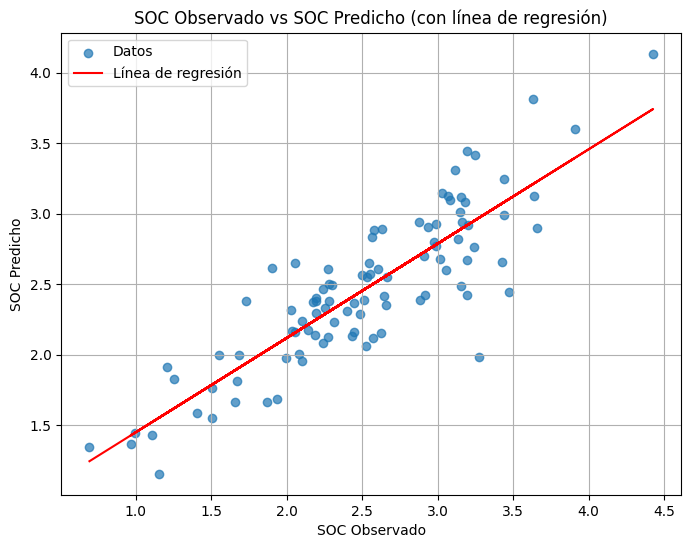

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Asegurarse de que test_pred_inv y test_true_inv sean NumPy arrays
test_pred_inv = np.array(test_pred_inv)
test_true_inv = np.array(test_true_inv)

# Ajustar un modelo de regresión lineal
model = LinearRegression()
model.fit(test_true_inv.reshape(-1, 1), test_pred_inv)

# Obtener los coeficientes y la intersección
slope = model.coef_[0].item()  # Convertir a escalar
intercept = model.intercept_.item()  # Convertir a escalar

# Calcular el R²
r_squared = model.score(test_true_inv.reshape(-1, 1), test_pred_inv)

# Mostrar el R²
print(f"R² de la regresión lineal: {r_squared:.4f}")

# Mostrar la ecuación de la línea de regresión
print(f"Ecuación de la línea de regresión: y = {slope:.4f}x + {intercept:.4f}")

# Graficar la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(test_true_inv, test_pred_inv, alpha=0.7, label='Datos')
plt.plot(test_true_inv, model.predict(test_true_inv.reshape(-1, 1)), color='red', label='Línea de regresión')
plt.xlabel('SOC Observado')
plt.ylabel('SOC Predicho')
plt.title('SOC Observado vs SOC Predicho (con línea de regresión)')
plt.legend()
plt.grid(True)
plt.show()


Random Forest con 10 árboles: Pérdida de entrenamiento: 0.0194, Pérdida de validación: 0.1030
Random Forest con 20 árboles: Pérdida de entrenamiento: 0.0133, Pérdida de validación: 0.1046
Random Forest con 50 árboles: Pérdida de entrenamiento: 0.0114, Pérdida de validación: 0.1115
Random Forest con 100 árboles: Pérdida de entrenamiento: 0.0114, Pérdida de validación: 0.1029
Random Forest con 200 árboles: Pérdida de entrenamiento: 0.0112, Pérdida de validación: 0.1041


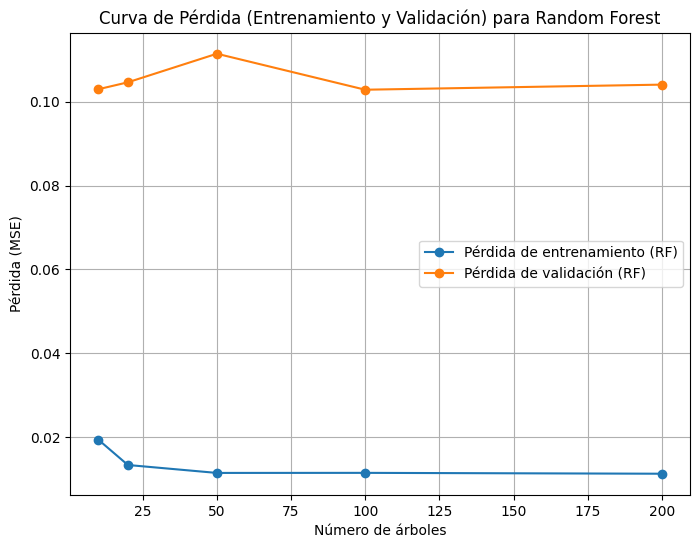

R² en el conjunto de prueba (RF): -0.6489
Error absoluto medio (MAE) en el conjunto de prueba (RF): 0.2709


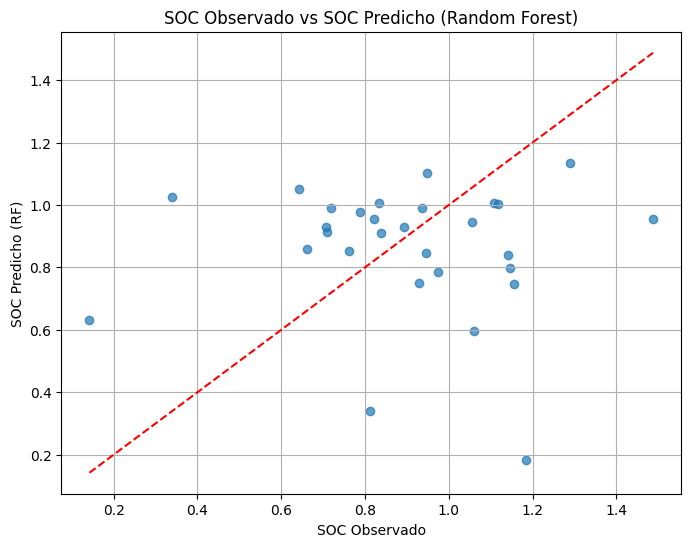

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Crear máscaras de entrenamiento, validación y prueba
n = df.shape[0]
train_idx, test_idx = train_test_split(range(n), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Extraer los datos de entrenamiento, validación y prueba
X_train = node_features[train_idx]
X_val = node_features[val_idx]
X_test = node_features[test_idx]

y_train = np.log(target[train_idx])
y_val = np.log(target[val_idx])
y_test = np.log(target[test_idx])

# Normalizar las características de los nodos utilizando solo el conjunto de entrenamiento
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)
std_train[std_train == 0] = 1  # Evitar división por cero en características con desviación estándar 0

X_train_norm = (X_train - mean_train) / std_train
X_val_norm = (X_val - mean_train) / std_train  # Usar la media y desviación del conjunto de entrenamiento
X_test_norm = (X_test - mean_train) / std_train  # Usar la media y desviación del conjunto de entrenamiento

# Crear listas para almacenar las pérdidas de entrenamiento y validación
train_losses_rf = []
val_losses_rf = []

# Entrenamos el modelo de Random Forest incrementando el número de árboles
num_trees = [10, 20, 50, 100, 200]  # Simular múltiples "épocas" incrementando el número de árboles
for n_trees in num_trees:
    # Crear el modelo de Random Forest con un número creciente de árboles
    rf_model = RandomForestRegressor(n_estimators=n_trees, random_state=42)

    # Entrenar el modelo
    rf_model.fit(X_train_norm, y_train)

    # Predicciones en el conjunto de entrenamiento
    y_train_pred = rf_model.predict(X_train_norm)
    train_loss = mean_squared_error(y_train, y_train_pred)
    train_losses_rf.append(train_loss)

    # Predicciones en el conjunto de validación
    y_val_pred = rf_model.predict(X_val_norm)
    val_loss = mean_squared_error(y_val, y_val_pred)
    val_losses_rf.append(val_loss)

    print(f"Random Forest con {n_trees} árboles: Pérdida de entrenamiento: {train_loss:.4f}, Pérdida de validación: {val_loss:.4f}")

# Graficar la función de pérdida para entrenamiento y validación
plt.figure(figsize=(8, 6))
plt.plot(num_trees, train_losses_rf, label='Pérdida de entrenamiento (RF)', marker='o')
plt.plot(num_trees, val_losses_rf, label='Pérdida de validación (RF)', marker='o')
plt.xlabel('Número de árboles')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Curva de Pérdida (Entrenamiento y Validación) para Random Forest')
plt.grid(True)
plt.show()

# Evaluación en el conjunto de prueba con el último modelo entrenado (con el mayor número de árboles)
y_test_pred = rf_model.predict(X_test_norm)

# Convertir los tensores a NumPy arrays (si son tensores de PyTorch)
y_test = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test
y_test_pred = y_test_pred if isinstance(y_test_pred, np.ndarray) else np.array(y_test_pred)

# Calcular R² y MAE en el conjunto de prueba
r2_rf = r2_score(y_test, y_test_pred)
mae_rf = np.mean(np.abs(y_test - y_test_pred))

print(f"R² en el conjunto de prueba (RF): {r2_rf:.4f}")
print(f"Error absoluto medio (MAE) en el conjunto de prueba (RF): {mae_rf:.4f}")

# Graficar valores SOC observados vs predichos (Random Forest)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('SOC Observado')
plt.ylabel('SOC Predicho (RF)')
plt.title('SOC Observado vs SOC Predicho (Random Forest)')
plt.grid(True)
plt.show()


R² de la regresión lineal: 0.0001
Ecuación de la línea de regresión: y = -0.0051x + 2.4313


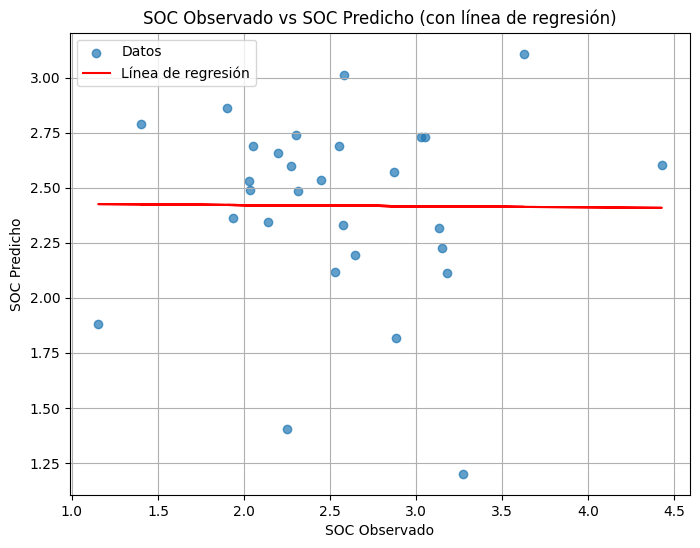

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Inversión del logaritmo para obtener los valores originales de SOC
test_pred_inv = np.exp(y_test_pred)
test_true_inv = np.exp(y_test)

# Asegurarse de que test_pred_inv y test_true_inv sean NumPy arrays
test_pred_inv = np.array(test_pred_inv)
test_true_inv = np.array(test_true_inv)

# Ajustar un modelo de regresión lineal
model = LinearRegression()
model.fit(test_true_inv.reshape(-1, 1), test_pred_inv)

# Obtener los coeficientes y la intersección
slope = model.coef_[0].item()  # Convertir a escalar
intercept = model.intercept_.item()  # Convertir a escalar

# Calcular el R²
r_squared = model.score(test_true_inv.reshape(-1, 1), test_pred_inv)

# Mostrar el R²
print(f"R² de la regresión lineal: {r_squared:.4f}")

# Mostrar la ecuación de la línea de regresión
print(f"Ecuación de la línea de regresión: y = {slope:.4f}x + {intercept:.4f}")

# Graficar la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(test_true_inv, test_pred_inv, alpha=0.7, label='Datos')
plt.plot(test_true_inv, model.predict(test_true_inv.reshape(-1, 1)), color='red', label='Línea de regresión')
plt.xlabel('SOC Observado')
plt.ylabel('SOC Predicho')
plt.title('SOC Observado vs SOC Predicho (con línea de regresión)')
plt.legend()
plt.grid(True)
plt.show()


R² de la regresión lineal (con datos filtrados): 0.1584
Ecuación de la línea de regresión (con datos filtrados): y = 0.2757x + 1.7855


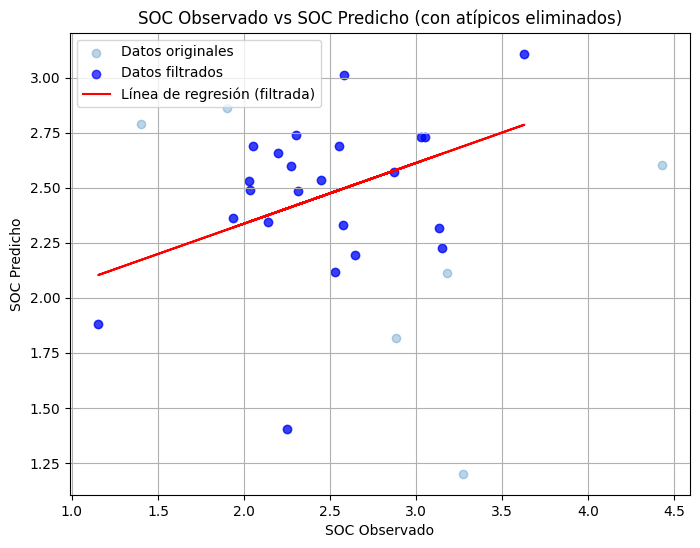

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Inversión del logaritmo para obtener los valores originales de SOC
test_pred_inv = np.exp(y_test_pred)
test_true_inv = np.exp(y_test)

# Asegurarse de que test_pred_inv y test_true_inv sean NumPy arrays
test_pred_inv = np.array(test_pred_inv)
test_true_inv = np.array(test_true_inv)

# Ajustar un modelo de regresión lineal
model = LinearRegression()
model.fit(test_true_inv.reshape(-1, 1), test_pred_inv)

# Predicciones del modelo
y_pred_line = model.predict(test_true_inv.reshape(-1, 1))

# Calcular el error absoluto (residuos)
residuals = np.abs(test_true_inv - test_pred_inv)

# Umbral para identificar atípicos: utilizamos 2 desviaciones estándar como referencia
threshold = 2 * np.std(residuals)

# Filtrar los datos eliminando los atípicos (residuos mayores al umbral)
mask = residuals < threshold
test_true_inv_filtered = test_true_inv[mask]
test_pred_inv_filtered = test_pred_inv[mask]

# Ajustar el modelo de nuevo, pero con los datos filtrados
model_filtered = LinearRegression()
model_filtered.fit(test_true_inv_filtered.reshape(-1, 1), test_pred_inv_filtered)

# Obtener los coeficientes y la intersección
slope_filtered = model_filtered.coef_[0].item()  # Convertir a escalar
intercept_filtered = model_filtered.intercept_.item()  # Convertir a escalar

# Calcular el R²
r_squared_filtered = model_filtered.score(test_true_inv_filtered.reshape(-1, 1), test_pred_inv_filtered)

# Mostrar el nuevo R²
print(f"R² de la regresión lineal (con datos filtrados): {r_squared_filtered:.4f}")

# Mostrar la ecuación de la línea de regresión filtrada
print(f"Ecuación de la línea de regresión (con datos filtrados): y = {slope_filtered:.4f}x + {intercept_filtered:.4f}")

# Graficar la nueva línea de regresión con los datos filtrados
plt.figure(figsize=(8, 6))
plt.scatter(test_true_inv, test_pred_inv, alpha=0.3, label='Datos originales')
plt.scatter(test_true_inv_filtered, test_pred_inv_filtered, alpha=0.7, label='Datos filtrados', color='blue')
plt.plot(test_true_inv_filtered, model_filtered.predict(test_true_inv_filtered.reshape(-1, 1)), color='red', label='Línea de regresión (filtrada)')
plt.xlabel('SOC Observado')
plt.ylabel('SOC Predicho')
plt.title('SOC Observado vs SOC Predicho (con atípicos eliminados)')
plt.legend()
plt.grid(True)
plt.show()
